In [73]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme()

import torch 
import torch.nn as nn 
import torch.optim as optim


from models.learned_qp_solver_1 import MLP_Init, learned_qp_solver
from scipy.io import loadmat
from torch.utils.data import Dataset, DataLoader
# torch.set_default_dtype(torch.float64)

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [75]:
num = 50
t = 0.05


vel_min = -1.5
vel_max = 1.5

acc_min = -3.0
acc_max = 3.0

jerk_min = -3.0
jerk_max = 3.0

theta_min = -3.14
theta_max = 3.14


In [76]:
# dataset_size = 100000

##################33

num_batch = 500

vel_samples = np.random.uniform(3*vel_min, 3*vel_max,  (num_batch, num)    )

# vel_samples = np.random.multivariate_normal(np.zeros(num), 2.0*np.identity(num),  (num_batch, )    )
# print(np.shape(vel_samples))
# kk

vel_samples = np.clip( vel_samples, vel_min, vel_max  )

# theta_init = np.random.uniform(theta_min, theta_max, (dataset_size, 1)  )
# vel_init = np.random.uniform(vel_min, vel_max, (dataset_size, 1)  )

theta_init = np.random.uniform(theta_min, theta_max)*np.ones((num_batch , 1)) 
vel_init = np.random.uniform(vel_min, vel_max)*np.ones((num_batch , 1)) 
acc_init = np.random.uniform(acc_min, acc_max, (num_batch, 1)  )


inp = np.hstack(( vel_samples, theta_init, vel_init))


# inp_mean = 0.0
# inp_std = 2.54
inp_mean = 0.0002667469940575574
inp_std = 2.5626480076020264

inp_mean, inp_std = inp.mean(), inp.std()



In [77]:
# Differentiable Layer
# num_batch = 400


mlp_init_inp_dim = np.shape(inp)[1]
mlp_init_hidden_dim = 1024
# mlp_init_out_dim = (2*nvar)**2+2*nvar+2*nvar
mlp_init_out_dim =  2*num+(2*num+2*num+2*(num-1)+2*(num-2))

# mlp_pred = MLP_Pred(mlp_pred_inp_dim, mlp_pred_hidden_dim, mlp_pred_out_dim  )
mlp_init = MLP_Init(mlp_init_inp_dim, mlp_init_hidden_dim, mlp_init_out_dim  )


model = learned_qp_solver(num_batch, num, t, mlp_init, inp_mean, inp_std).to(device)

model.load_state_dict(torch.load('./weights/learned_qp_1.pth'))
model.eval()


learned_qp_solver(
  (mlp_init): MLP_Init(
    (mlp): Sequential(
      (0): Linear(in_features=52, out_features=1024, bias=True)
      (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Linear(in_features=1024, out_features=1024, bias=True)
      (4): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (5): ReLU()
      (6): Linear(in_features=1024, out_features=494, bias=True)
    )
  )
  (rcl_loss): MSELoss()
)

[52.3218      1.1124697   0.98740613  0.8399136   0.7495266   0.6621363
  0.5712518   0.50215304  0.42557666  0.38804352  0.33041316  0.2942646
  0.26660645  0.2344684   0.21404223  0.1866437   0.17370561  0.15717995
  0.14462191  0.13285938  0.12214197  0.12061477  0.11319028  0.10607085
  0.10302575  0.10079543  0.10166018  0.09140945  0.08972271  0.09085754
  0.0938449   0.09054577  0.08985104  0.08809631  0.0907496   0.09070973
  0.08683892  0.08937234  0.08750992  0.08629656  0.08560776  0.08491517
  0.08541577  0.08467302  0.08452512  0.08335478  0.08347802  0.08317261
  0.08555458  0.0829601 ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


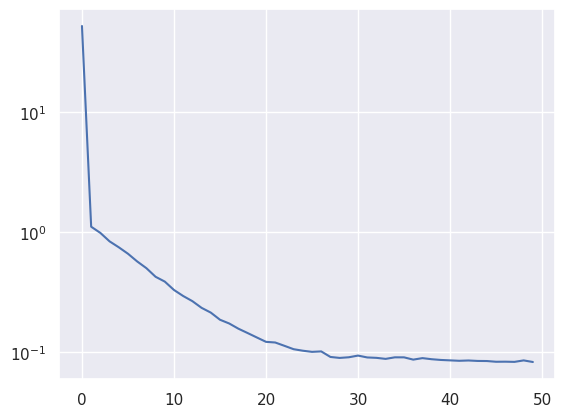

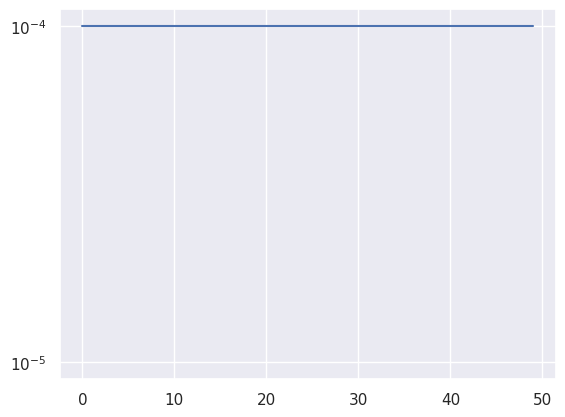

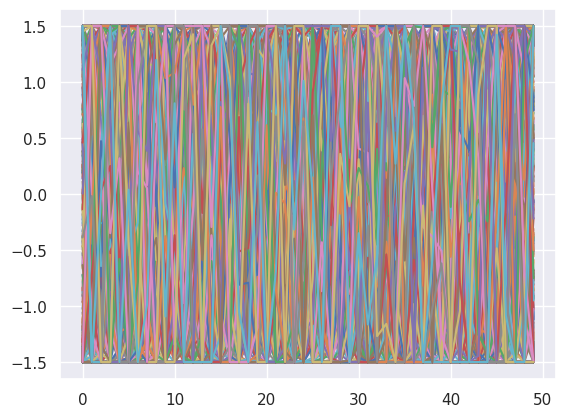

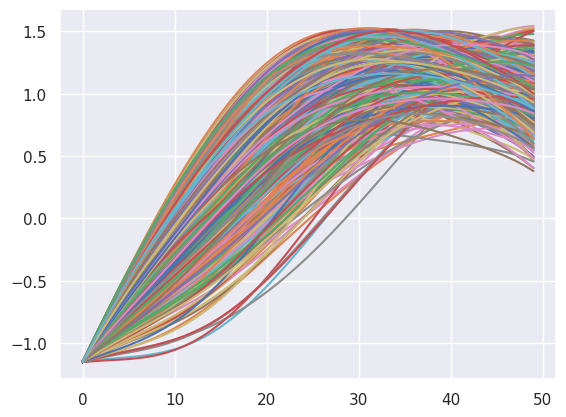

In [78]:
# idx = np.random.randint(0, dataset_size)
# idx = 370
# print(idx)




#################3


inp_test = inp
inp_test = torch.tensor(inp_test).float()
inp_test = inp_test.to(device)
# inp_test = torch.vstack([inp_test] * num_batch)
inp_norm_test = (inp_test - inp_mean) / inp_std

theta_init_test = theta_init[0]
theta_init_test = torch.tensor(theta_init_test).float()
theta_init_test = theta_init_test.to(device)
# theta_init_test = torch.vstack([theta_init_test] * num_batch)


vel_init_test = vel_init[0]
vel_init_test = torch.tensor(vel_init_test).float()
vel_init_test = vel_init_test.to(device)

acc_init_test = acc_init[0]
acc_init_test = torch.tensor(acc_init_test).float()
acc_init_test = acc_init_test.to(device)


# vel_init_test = torch.vstack([vel_init_test] * num_batch)


vel_samples_test = vel_samples
vel_samples_test = torch.tensor(vel_samples_test).float()
vel_samples_test = vel_samples_test.to(device)
# vel_samples_test = torch.vstack([vel_samples_test] * num_batch)

with torch.no_grad():
    vel_projected, res_primal_stack, res_fixed_point_stack, accumulated_res_primal, accumulated_res_fixed_point = model.decoder_function(inp_norm_test, vel_init_test, acc_init_test,  vel_samples_test, vel_max, vel_min, acc_max, acc_min, jerk_max, jerk_min, theta_min, theta_max, theta_init_test)



print(res_fixed_point_stack[:, 0].cpu().detach().numpy())
print(res_primal_stack[:, 0].cpu().detach().numpy())

plt.figure(1)
plt.plot(res_fixed_point_stack[:, 0].cpu().detach().numpy())
plt.yscale('log')


plt.figure(2)
plt.plot(res_primal_stack[:, 0].cpu().detach().numpy()+0.0001)
plt.yscale('log')


plt.figure(3)

plt.plot(vel_samples_test.T.cpu().detach().numpy())

plt.figure(4)
plt.plot(vel_projected.T.cpu().detach().numpy())

plt.show()


